In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [87]:
def parse_res(file):
    with open(file, 'r') as f:
        lines = f.read().split("\n")
        
    data = []
    for line in lines[1:]:
        if line:
            script, time = list(map(lambda l : l.strip(), line.split(":"))
            data.append([script.replace(".sh", ""), float(time)])
    
    df = pd.DataFrame(data, columns=["test_name", "exec_time"])
    return df
parse_res('eval_results/run1/no_commutativity/oneliners/par.res')

SyntaxError: invalid syntax (<ipython-input-87-01c192b8561b>, line 9)

In [88]:
def plot_barchart_against(dfs: list, y_axis="exec_time", test_names=None, title=""):
    df1 = dfs[0][1]
    if test_names is not None:
        df1 = df1[df1["test_name"].isin(test_names)]
        labels = sorted(test_names)
    else:
        labels = sorted(df1.test_name.unique())

    x = np.arange(len(labels))  # the label locations
    width = 1/(len(dfs))*4/5  # the width of the bars

    rects = []
    for df_name, df in dfs:
        rects.append(df)

    bar_height = [[] for i in range(len(rects))]
    error_height = [[] for i in range(len(rects))]

    for label in labels:
        for i, rect in enumerate(rects):
            try:
                bar_height[i].append(rect.loc[rect["test_name"] == label][y_axis].mean())
                error_height[i].append(rect.loc[rect["test_name"] == label][y_axis].std())
            except:
                print("plot_shart_against: failed: ", label)
        

    fig, ax = plt.subplots(figsize=(20,10))
    for i in range(len(dfs)):
        label = ""
        df_name = dfs[i][0]
        offset = (i -  int(len(dfs)/2))
        if len(dfs)%2 == 0:
            offset += 1/2
        ax.bar(x + offset*width, bar_height[i], width, yerr=error_height[i], label=label+df_name)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('ms')
    # ax.set_title('')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xticks(rotation=90)
    plt.title(title)
    ax.legend()
    
    plt.show()

1.1262466659575634


<AxesSubplot:xlabel='benchmark', ylabel='speedup'>

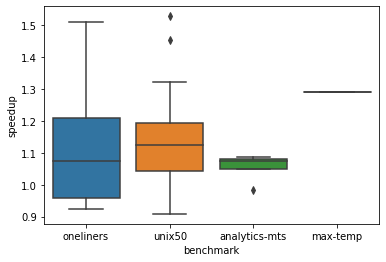

In [94]:
benchmarks = ["oneliners", "unix50", "analytics-mts", "max-temp"]
modes = ["no_commutativity", "with_commutativity" ]
runs = ['1']
all_benchs = []
for benchmark in benchmarks:
    dfs = []
    for mode in modes:
        df = parse_res(f'eval_results/run1/{mode}/{benchmark}/par.res')
        dfs.append((mode.replace("_", " "), df))
        
    all_benchs.append((benchmark, dfs))
#     plot_barchart_against(dfs, title=benchmark)


speedups=[]
for bench, dfs in all_benchs:
    new_df = {}
    name1, df1 = dfs[0]
    name2, df2 = dfs[1]
    new_df['test_name'] = df1['test_name']
    new_df['speedup'] = df1.exec_time/df2.exec_time 
    
    df = pd.concat(new_df,axis=1)
    speedups.append((bench, df))

summary = []
for bench, df in speedups:
    df['benchmark'] = bench
    summary.append(df)
    
summary_df = pd.concat(summary, axis = 0)
# sns.legend
print(summary_df.speedup.mean())
sns.boxplot( data=summary_df, x = 'benchmark', y = 'speedup')

# print(all_benchs)